This jupyter notebook is prepared by “Andrew Tuazon”


# Load Data and perform basic EDA 

## I. import libraries: pandas, numpy, matplotlib (set %matplotlib inline), matplotlib’s pyplot, seaborn, missingno, scipy’s stats, sklearn (1 pt)

In [258]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st
import missingno as msno
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections import Counter
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import make_scorer

## II. import the data to a dataframe and show the count of rows and columns (1 pt)

In [259]:
df = pd.read_csv('/content/drive/MyDrive/hrdata2.csv', index_col=0)
df.shape

(8955, 14)

## III. Show the top 5 and last 5 rows (1 pt)

In [260]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,>4,47,0.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,21.0,50-99,Funded Startup,4,8,0.0
7,402,city_46,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13.0,<10,Pvt Ltd,>4,18,1.0
8,27107,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,7.0,50-99,Pvt Ltd,1,46,1.0
11,23853,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,5.0,5000-9999,Pvt Ltd,1,108,0.0


In [261]:
df.tail()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
19147,21319,city_21,0.624,Male,No relevent experience,Full time course,Graduate,STEM,1.0,100-500,Pvt Ltd,1,52,1.0
19149,251,city_103,0.920,Male,Has relevent experience,no_enrollment,Masters,STEM,9.0,50-99,Pvt Ltd,1,36,1.0
19150,32313,city_160,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,10.0,100-500,Public Sector,3,23,0.0
19152,29754,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,Humanities,7.0,10/49,Funded Startup,1,25,0.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21.0,50-99,Pvt Ltd,4,44,0.0


## IV. Show how many columns have null values

In [262]:
nulls = df.isnull().sum().to_frame('nulls') #sum up nulls and make a df
nulls.sort_values("nulls", inplace = True, ascending = False) #sort it by descending order
for index, row in nulls.iterrows(): #print it in well formatted way
  print(index, row[0])

enrollee_id 0
city 0
city_development_index 0
gender 0
relevent_experience 0
enrolled_university 0
education_level 0
major_discipline 0
experience 0
company_size 0
company_type 0
last_new_job 0
training_hours 0
target 0


## V. Plot the count of target and discuss its imbalances and probably issues and solutions

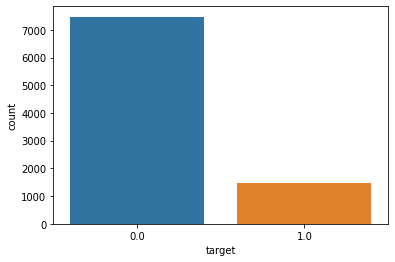

In [263]:
sns.countplot(data=df, x="target")

There is a significant number of 0 values indicating that an employee is not looking for a job change, compared to the number of 1 values, indicating that an employee is looking for a job change. Models trained with this imbalance in target values will be accurate in calssifying 0s, but not with classifying ones. Some solutions to this may be adding more training records for 1s classifications to the dataset, using random over-sampling on the 1s class, using random under-sampling on the dominant 0s class, and trying an algorithm like decision tree to tree ensemble like a random forest.

#  Feature Selection and Pre-processing 

## I. Preprocessing City: 

### I. Plot no. of records per city so that the highest city counts are shown in descending order

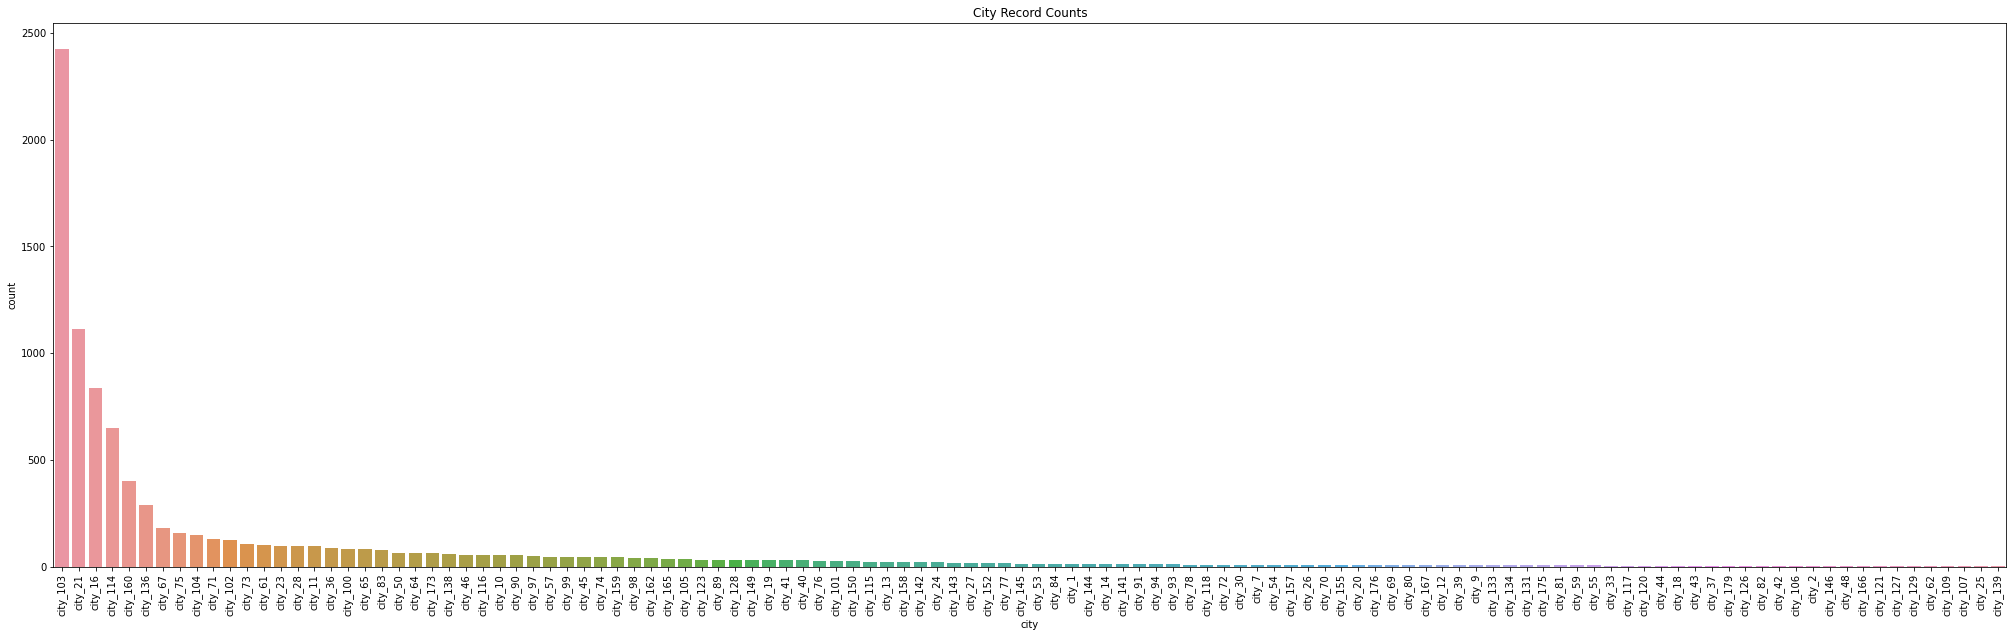

In [264]:
df.sort_values(by='city', inplace=True)
plt.figure(figsize = (35,10))
ax = sns.countplot(x = 'city', data = df, order = df['city'].value_counts().index)
ax.set(title='City Record Counts')
plt.xticks(rotation = 90)
plt.show()


###II. How many rows belong to the count-wise top 4 cities in total and how many for the remaining? (The plot you have generated in 2.i.i should help you to identify those cities)

In [265]:
df['city'].value_counts()

city_103    2426
city_21     1111
city_16      836
city_114     648
city_160     401
            ... 
city_62        1
city_109       1
city_107       1
city_25        1
city_139       1
Name: city, Length: 116, dtype: int64

Top 4 cities have 5021 records, remaining cities have 8955 - 5021 = 3934 records combined.

### III. Replace the city name with city_others if the city name is not within the top 4 city names.

In [266]:
top = ['city_103', 'city_21', 'city_16', 'city_114']
unique_cities = df['city'].unique()
cities_list = unique_cities.tolist()
for x in top:
  cities_list.remove(x)
df.loc[df['city'].isin(cities_list), 'city'] = 'city_other'

### IV. Show some sample data that the records have changed appropriately

In [267]:
df['city'].value_counts()

city_other    3934
city_103      2426
city_21       1111
city_16        836
city_114       648
Name: city, dtype: int64

## II. Education Level

### I. Show the unique values of education level.

In [268]:
unique_ed_level = df['education_level'].unique()
unique_ed_level

array(['Graduate', 'Masters', 'Phd'], dtype=object)

###II. Replace the value of Education level column like ordinal values, "Graduate" -> 0, Masters->1, and Phd -> 2

In [269]:
def replace_level(x):
  if x == 'Graduate':
    return 0
  elif x == 'Masters':
    return 1
  elif x == 'Phd':
    return 2
df['education_level'] = df['education_level'].apply(replace_level)

### III. Show some sample data that the records have changed appropriately

In [270]:
df['education_level'].value_counts()

0    6252
1    2449
2     254
Name: education_level, dtype: int64

## III. company_size column

### I. Show the unique values of the company_size column

In [271]:
unique_size = df['company_size'].unique()
unique_size

array(['5000-9999', '50-99', '<10', '100-500', '500-999', '1000-4999',
       '10/49', '10000+'], dtype=object)

### II. Change the values of the company_size column from 0 to 7 where 0 is <10 and 7 is 10000+. The order of the numbers should be based on the values of the column-like an ordinary variable. 

In [272]:
def replace_size(x):
  if x == '<10':
    return 0
  elif x == '10/49':
    return 1
  elif x == '50-99':
    return 2
  elif x == '100-500':
    return 3
  elif x == '500-999':
    return 4
  elif x == '1000-4999':
    return 5
  elif x == '5000-9999':
    return 6
  elif x == '10000+':
    return 7
df['company_size'] = df['company_size'].apply(replace_size)

### III. Show the updated unique values

In [273]:
df['company_size'].unique()

array([6, 2, 0, 3, 4, 5, 1, 7])

## IV. Last_new_job

### I. Show the unique values of the last_new_job column

In [274]:
unique_job = df['last_new_job'].unique()
unique_job

array(['1', '>4', '2', 'never', '4', '3'], dtype=object)

### II. Convert the values of this column to never->0, 1->1,....>4 -->5

In [275]:
def replace_job(x):
  if x == 'never':
    return 0
  elif x == '1':
    return 1
  elif x == '2':
    return 2
  elif x == '3':
    return 3
  elif x == '4':
    return 4
  elif x == '>4':
    return 5
df['last_new_job'] = df['last_new_job'].apply(replace_job)

### III. Show the updated values

In [276]:
df['last_new_job'].unique()

array([1, 5, 2, 0, 4, 3])

## V. Other columns

### I. Show the unique values of company_type, major_descipline, enrolled_university, relevant_experience, gender, and updated city column

In [277]:
print(df['company_type'].unique())
print(df['major_discipline'].unique())
print(df['enrolled_university'].unique())
print(df['relevent_experience'].unique())
print(df['gender'].unique())
print(df['city'].unique())

['Pvt Ltd' 'Public Sector' 'Early Stage Startup' 'Funded Startup' 'Other'
 'NGO']
['STEM' 'Other' 'Humanities' 'Arts' 'Business Degree' 'No Major']
['Full time course' 'no_enrollment' 'Part time course']
['Has relevent experience' 'No relevent experience']
['Male' 'Female' 'Other']
['city_other' 'city_103' 'city_114' 'city_16' 'city_21']


### II. As one-hot encoding is a bit strict, use panda's get_dummies function to create binary columns for the values of the following columns: 

#### I. company_type

In [278]:
dummy_company_type = pd.get_dummies(df['company_type'], prefix='company_type_')
df = pd.merge(
    left=df,
    right=dummy_company_type,
    left_index=True,
    right_index=True,
)
df = df.drop(columns='company_type')

#### II. major_discipline

In [279]:
dummy_major_discipline = pd.get_dummies(df['major_discipline'], prefix='major_discipline_')
df = pd.merge(
    left=df,
    right=dummy_major_discipline,
    left_index=True,
    right_index=True,
)
df = df.drop(columns='major_discipline')

#### III. enrolled_university

In [280]:
dummy_enrolled_university = pd.get_dummies(df['enrolled_university'], prefix='enrolled_university_')
df = pd.merge(
    left=df,
    right=dummy_enrolled_university,
    left_index=True,
    right_index=True,
)
df = df.drop(columns='enrolled_university')

#### IV. relevent_experience

In [281]:
dummy_relevent_experience = pd.get_dummies(df['relevent_experience'], prefix='relevent_experience_')
df = pd.merge(
    left=df,
    right=dummy_relevent_experience,
    left_index=True,
    right_index=True,
)
df = df.drop(columns='relevent_experience')

#### IV. gender

In [282]:
dummy_gender = pd.get_dummies(df['gender'], prefix='gender_')
df = pd.merge(
    left=df,
    right=dummy_gender,
    left_index=True,
    right_index=True,
)
df = df.drop(columns='gender')

#### IV. updated city

In [283]:
dummy_city = pd.get_dummies(df['city'], prefix='city_')
df = pd.merge(
    left=df,
    right=dummy_city,
    left_index=True,
    right_index=True,
)
df = df.drop(columns='city')

### III. Show the top 5 and last 5 rows to show that the table has changed You must set this first before showing the data frame as many columns will be hidden due to the large number of columns

In [284]:
pd.set_option('display.max_columns', None)
df.head()

,enrollee_id,city_development_index,education_level,experience,company_size,last_new_job,training_hours,target,company_type__Early Stage Startup,company_type__Funded Startup,company_type__NGO,company_type__Other,company_type__Public Sector,company_type__Pvt Ltd,major_discipline__Arts,major_discipline__Business Degree,major_discipline__Humanities,major_discipline__No Major,major_discipline__Other,major_discipline__STEM,enrolled_university__Full time course,enrolled_university__Part time course,enrolled_university__no_enrollment,relevent_experience__Has relevent experience,relevent_experience__No relevent experience,gender__Female,gender__Male,gender__Other,city__city_103,city__city_114,city__city_16,city__city_21,city__city_other
15172,14791,0.847,0,10.0,6,1,9,0.0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1
6676,15070,0.847,0,15.0,2,5,152,0.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1
12053,23071,0.847,1,10.0,2,1,67,0.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1
11082,11349,0.847,0,14.0,0,1,33,0.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1
8626,10291,0.847,0,14.0,0,2,20,0.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,1


In [285]:
df.tail()

,enrollee_id,city_development_index,education_level,experience,company_size,last_new_job,training_hours,target,company_type__Early Stage Startup,company_type__Funded Startup,company_type__NGO,company_type__Other,company_type__Public Sector,company_type__Pvt Ltd,major_discipline__Arts,major_discipline__Business Degree,major_discipline__Humanities,major_discipline__No Major,major_discipline__Other,major_discipline__STEM,enrolled_university__Full time course,enrolled_university__Part time course,enrolled_university__no_enrollment,relevent_experience__Has relevent experience,relevent_experience__No relevent experience,gender__Female,gender__Male,gender__Other,city__city_103,city__city_114,city__city_16,city__city_21,city__city_other
15812,4454,0.915,0,15.0,3,1,204,0.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1
12128,21142,0.915,0,9.0,2,2,55,0.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1
17470,26737,0.915,0,21.0,2,5,50,0.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1
18809,28618,0.915,0,5.0,4,1,28,0.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1
5744,10146,0.915,0,4.0,0,2,46,1.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1


### IV. Also, show the shape of the table

In [286]:
df.shape

(8955, 33)

### VI. Drop the enrollee_id and any duplicate columns

In [287]:
df = df.drop(columns='enrollee_id')

### VII. Feature Scaling

#### I. Use sklearn.preprocessing's MinMaxScaler to perform min max scaling to all the columns

In [288]:
scaler = preprocessing.MinMaxScaler()
columns = df.columns.tolist()
df_scaled = scaler.fit_transform(df.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=columns)

#### II. Show sample records that show some the scaled records

In [289]:
df_scaled

,city_development_index,education_level,experience,company_size,last_new_job,training_hours,target,company_type__Early Stage Startup,company_type__Funded Startup,company_type__NGO,company_type__Other,company_type__Public Sector,company_type__Pvt Ltd,major_discipline__Arts,major_discipline__Business Degree,major_discipline__Humanities,major_discipline__No Major,major_discipline__Other,major_discipline__STEM,enrolled_university__Full time course,enrolled_university__Part time course,enrolled_university__no_enrollment,relevent_experience__Has relevent experience,relevent_experience__No relevent experience,gender__Female,gender__Male,gender__Other,city__city_103,city__city_114,city__city_16,city__city_21,city__city_other
0,0.796407,0.0,0.476190,0.857143,0.2,0.023881,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.796407,0.0,0.714286,0.285714,1.0,0.450746,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.796407,0.5,0.476190,0.285714,0.2,0.197015,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.796407,0.0,0.666667,0.000000,0.2,0.095522,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.796407,0.0,0.666667,0.000000,0.4,0.056716,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8950,0.932136,0.0,0.714286,0.428571,0.2,0.605970,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
8951,0.932136,0.0,0.428571,0.285714,0.4,0.161194,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
8952,0.932136,0.0,1.000000,0.285714,1.0,0.146269,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
8953,0.932136,0.0,0.238095,0.571429,0.2,0.080597,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### VIII. Move the target column to the last column of the data frame and show that it has changed


In [290]:
target_col = df_scaled.pop('target')
df_scaled.insert(len(df_scaled.columns), 'target', target_col)
df_scaled

,city_development_index,education_level,experience,company_size,last_new_job,training_hours,company_type__Early Stage Startup,company_type__Funded Startup,company_type__NGO,company_type__Other,company_type__Public Sector,company_type__Pvt Ltd,major_discipline__Arts,major_discipline__Business Degree,major_discipline__Humanities,major_discipline__No Major,major_discipline__Other,major_discipline__STEM,enrolled_university__Full time course,enrolled_university__Part time course,enrolled_university__no_enrollment,relevent_experience__Has relevent experience,relevent_experience__No relevent experience,gender__Female,gender__Male,gender__Other,city__city_103,city__city_114,city__city_16,city__city_21,city__city_other,target
0,0.796407,0.0,0.476190,0.857143,0.2,0.023881,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.796407,0.0,0.714286,0.285714,1.0,0.450746,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.796407,0.5,0.476190,0.285714,0.2,0.197015,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.796407,0.0,0.666667,0.000000,0.2,0.095522,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.796407,0.0,0.666667,0.000000,0.4,0.056716,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8950,0.932136,0.0,0.714286,0.428571,0.2,0.605970,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8951,0.932136,0.0,0.428571,0.285714,0.4,0.161194,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8952,0.932136,0.0,1.000000,0.285714,1.0,0.146269,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8953,0.932136,0.0,0.238095,0.571429,0.2,0.080597,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# X/Y and Training/Test Split with stratified sampling and SMOTE

## I. Copy all the features into X and the target to Y

In [291]:
X = df_scaled.columns.tolist()
X.remove('target')
X = df_scaled[df_scaled.columns[:31]]
y = df_scaled[df_scaled.columns[31]]


## II. Show the ratio of 1 and 0 in Y

In [292]:
print("1s Ratio: ", y.value_counts()[1] / y.shape[0]) 
print("0s Ratio: ", y.value_counts()[0] / y.shape[0])

1s Ratio:  0.16560580681183695
0s Ratio:  0.834394193188163


## III. Use sklearn's train_test_split to split the data set into training and test sets. There should be 30% records in the test set. The random_stat should be 0. As we want to have the same ratio of 0 and 1 in the test set, use the stratify parameter to the Y.   

In [293]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0,stratify=y)

## IV. Show the ratio of 1 and 0 in y_train and then y_test

In [294]:
print("1s Ratio: ", y_train.value_counts()[1] / y_train.shape[0]) 
print("0s Ratio: ", y_train.value_counts()[0] / y_train.shape[0])

1s Ratio:  0.1656030631780472
0s Ratio:  0.8343969368219528


In [295]:
print("1s Ratio: ", y_test.value_counts()[1] / y_test.shape[0]) 
print("0s Ratio: ", y_test.value_counts()[0] / y_test.shape[0])

1s Ratio:  0.1656122069222181
0s Ratio:  0.8343877930777819


## V. Rebalance

In [296]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

## VI. Show the ratio of 0 and 1 in Y_train after rebalancing. (do you have 50% of each class now?)

In [297]:
print("1s Ratio: ", y_resampled.value_counts()[1] / y_resampled.shape[0]) 
print("0s Ratio: ", y_resampled.value_counts()[0] / y_resampled.shape[0])
y_resampled.value_counts()

1s Ratio:  0.5
0s Ratio:  0.5


0.0    5230
1.0    5230
Name: target, dtype: int64

We now have 50% of each class

#PCA and Logistic Regression

## I. As we have many features now, we would like to do principal component analysis (you have learned it in datacamp). As part of it, create pipeline to find how many dimensions give you the best logistic regression model. 

>1 0.708 (0.012)
>2 0.705 (0.012)
>3 0.703 (0.011)
>4 0.706 (0.011)
>5 0.707 (0.011)
>6 0.707 (0.011)
>7 0.712 (0.011)
>8 0.735 (0.011)
>9 0.736 (0.011)
>10 0.737 (0.012)
>11 0.738 (0.012)
>12 0.738 (0.012)
>13 0.738 (0.012)
>14 0.737 (0.012)
>15 0.736 (0.012)
>16 0.734 (0.012)
>17 0.735 (0.012)
>18 0.735 (0.011)
>19 0.734 (0.012)
>20 0.738 (0.013)
>21 0.738 (0.013)
>22 0.738 (0.013)
>23 0.738 (0.013)
>24 0.739 (0.013)
>25 0.739 (0.013)
>26 0.739 (0.013)
>27 0.739 (0.013)
>28 0.739 (0.013)
>29 0.739 (0.013)
>30 0.739 (0.013)
>31 0.739 (0.013)


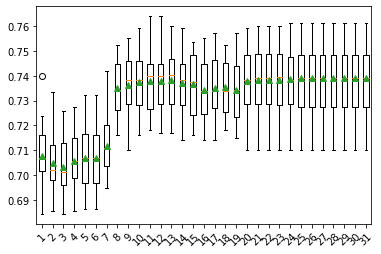

In [298]:
# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(1,32):
		steps = [('pca', PCA(n_components=i)), ('m', LogisticRegression())]
		models[str(i)] = Pipeline(steps=steps)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
  
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X_resampled, y_resampled)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation=45)
plt.show()

## II. Based on the number of features chosen in the above step, use the test set to evaluate the model for accuracy (the code right after the plot can give you an idea about it.). Use sklearn.metrics import accuracy_score for accuracy (the google colab link in the classification module should help with it)

In [299]:
# define the model
steps = [('pca', PCA(n_components=10)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)
# fit the model on the whole dataset
model.fit(X_resampled, y_resampled)
yhat = model.predict(X_test)
print(accuracy_score(y_test, yhat))

0.8224786006698921


## III. Show the confusion matrix and interpret the numbers in the confusion matrix

In [300]:
y_train_pred = cross_val_predict(model, X_resampled, y_resampled, cv=3)
print(confusion_matrix(y_resampled, y_train_pred))

[[4661  569]
 [2163 3067]]


## IV. Show precision, recall, and f1 score

In [301]:
precision_score(y_resampled, y_train_pred)

0.8435093509350935

In [302]:
recall_score(y_resampled, y_train_pred) 

0.5864244741873805

In [303]:
f1_score(y_resampled, y_train_pred)

0.691856530566208

## V. Plot ROC curve and find AUC

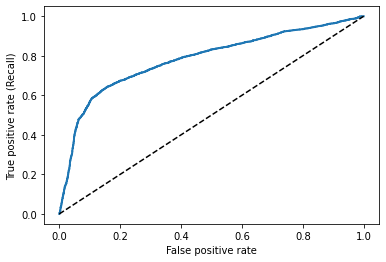

AUC: 0.782714


In [304]:
y_scores = cross_val_predict(model, X_resampled, y_resampled, cv=3,
 method="decision_function")
fpr, tpr, thresholds = roc_curve(y_resampled, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
 plt.plot(fpr, tpr, linewidth=2, label=label)
 plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
 
plot_roc_curve(fpr, tpr)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate (Recall)")
plt.show()

print("AUC: %f" % roc_auc_score(y_resampled, y_scores))

## VI. Plot precision-recall curve for different thresholds and discuss the plot

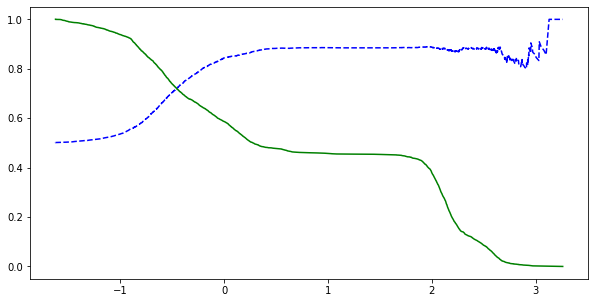

In [305]:
precisions, recalls, thresholds = precision_recall_curve(y_resampled, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  
plt.figure(figsize=(10,5))
plt.xlabel('Recall')
plt.ylabel('Precision')
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Using a decision threshold for somewhere between -1 and 0 gives us the ideal point for maximizing precision vs recall. After this, we start to lose precision in our predictions.

# Softmax Regression

## I. How softmax regression is related to logistic regression? What library can you use for softmax regression?

Softmax regression is a classification algorithm that is a generalization of logistic regression. Softmax has the ability to predict multiple classes, instead of just a binary classification with logistic regression. You can use the mlxtend library for Softmax Regression

# KNN

## I. Use sklearn's KNN classifier to train (with k=  10) and predict the model based on the unbalanced training set (the training set before rebalancing) and test it and show the confusion matrix and classification report

In [306]:
classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2141  101]
 [ 296  149]]
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.92      2242
         1.0       0.60      0.33      0.43       445

    accuracy                           0.85      2687
   macro avg       0.74      0.64      0.67      2687
weighted avg       0.83      0.85      0.83      2687



## II. Use sklearn's KNN classifier to train (with k=  10) and predict the model based on the rebalanced training set and test it and show the confusion matrix and classification report

In [307]:
classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(X_resampled, y_resampled)
y_pred = classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1697  545]
 [ 175  270]]
              precision    recall  f1-score   support

         0.0       0.91      0.76      0.82      2242
         1.0       0.33      0.61      0.43       445

    accuracy                           0.73      2687
   macro avg       0.62      0.68      0.63      2687
weighted avg       0.81      0.73      0.76      2687



## III. Use grid search to tune the following hyperparameters of KNN: number of neighbors (between 1 and 20), weights  (uniform or distance), and metrics (Euclidean, Manhattan, or Minkowski distance) to use for KNN

In [ ]:
knn_params = {
    "n_neighbors": range(1, 21),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"],
}

knn = KNeighborsClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
grid_search = GridSearchCV(estimator=knn, param_grid=knn_params, n_jobs=-1, cv=cv, scoring="accuracy", refit = True)
grid_results = grid_search.fit(X_resampled, y_resampled)

## IV. The above grid search process can take a couple of minutes. After completing the process, print the best_params_

In [309]:
print(grid_results.best_params_)

{'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}


## V. Based on the result from grid search, use the parameters to train a model, test it with test set, and then print the confusion matrix and classification report. Also, show the AUC of ROC.

In [310]:
final_model = knn.set_params(**grid_results.best_params_)
final_model.fit(X_resampled, y_resampled)
y_pred = final_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC: %f" % roc_auc_score(y_test, y_pred))

[[1921  321]
 [ 254  191]]
              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87      2242
         1.0       0.37      0.43      0.40       445

    accuracy                           0.79      2687
   macro avg       0.63      0.64      0.63      2687
weighted avg       0.80      0.79      0.79      2687

AUC: 0.643019


## VI. Use PCA and based on that train model, test it and then print the confusion matrix and classification report. Also, show the AUC of ROC

In [312]:
# define the model
steps = [('pca', PCA(n_components=10)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)
# fit the model on the whole dataset
model.fit(X_resampled, y_resampled)
y_hat = model.predict(X_test)
print(confusion_matrix(y_test, y_hat))
print(classification_report(y_test, y_hat))
print("AUC: %f" % roc_auc_score(y_test, y_hat))

[[1964  278]
 [ 199  246]]
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.89      2242
         1.0       0.47      0.55      0.51       445

    accuracy                           0.82      2687
   macro avg       0.69      0.71      0.70      2687
weighted avg       0.84      0.82      0.83      2687

AUC: 0.714406


## VII. A short discussion on the 4 models and their differences.

KNN classifier with k=10 trained on unbalanced training set is very accurate on TN as expected due to the high number of 0 classifications in the training set an not as accurate on predicting TP. Compare to the KNN classifier trained on balanced training set and k=10 and is able to predict more TP, but at expense of higher missclassification. KNN classifier trained with best parameters and resampled training set is better than second classifier at detecting TN, but not as good with TP. PCA using n_components=10 seems to perform better than KNN classifiers 2 & 3 in terms of precision and accuracy.


# Naive Bayes

## I. Train a model with GaussianNB, test it and then print the confusion matrix and classification report. Also, plot ROC curve and show the AUC of ROC, and the count of the number of misclassification.

[[1921  321]
 [ 254  191]]
              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87      2242
         1.0       0.37      0.43      0.40       445

    accuracy                           0.79      2687
   macro avg       0.63      0.64      0.63      2687
weighted avg       0.80      0.79      0.79      2687



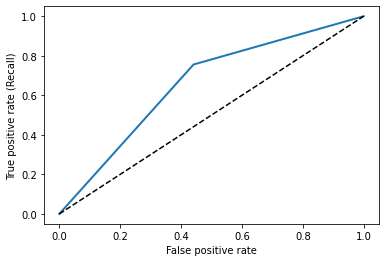

AUC: 0.657361
Misclassified samples: 1145


In [313]:
gnb = GaussianNB()
gnb.fit(X_resampled, y_resampled)
y_pred_gnb = gnb.predict(X_test)
y_prob_pred_gnb = gnb.predict_proba(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
count_misclassified = (y_test != y_pred_gnb).sum()

y_scores = cross_val_predict(gnb, X_resampled, y_resampled, cv=3)
fpr, tpr, thresholds = roc_curve(y_resampled, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
 
plot_roc_curve(fpr, tpr)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate (Recall)")
plt.show()

print("AUC: %f" % roc_auc_score(y_resampled, y_scores))

print('Misclassified samples: {}'.format(count_misclassified))

## II. Train a model with CategoricalNB, test it and then print the confusion matrix and classification report. Also, plot ROC curve, and show the AUC of ROC and the count of the number of misclassification.


[[1921  321]
 [ 254  191]]
              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87      2242
         1.0       0.37      0.43      0.40       445

    accuracy                           0.79      2687
   macro avg       0.63      0.64      0.63      2687
weighted avg       0.80      0.79      0.79      2687



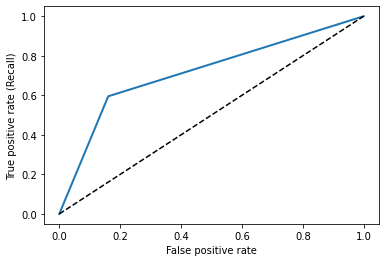

AUC: 0.717113
Misclassified samples: 618


In [314]:
cnb = CategoricalNB()
cnb.fit(X_resampled, y_resampled)
y_pred_cnb = cnb.predict(X_test)
y_prob_pred_cnb = cnb.predict_proba(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
count_misclassified = (y_test != y_pred_cnb).sum()

y_scores = cross_val_predict(cnb, X_resampled, y_resampled, cv=3)
fpr, tpr, thresholds = roc_curve(y_resampled, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
 
plot_roc_curve(fpr, tpr)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate (Recall)")
plt.show()

print("AUC: %f" % roc_auc_score(y_resampled, y_scores))

print('Misclassified samples: {}'.format(count_misclassified))

# Support Vector Machine

## I. Build a support vector machine model using SVC. Use grid search to tune some parameters and then based on that show the best parameters found

In [317]:
param_grid = {'C': [0.1,1, 10], 'gamma': [1,0.1,0.01], 'kernel': ['rbf', 'sigmoid', 'poly']} # create list of paraeters you would like to tune. We have already gone thorugh these parameters in our lecture and note


grid = GridSearchCV(SVC(), param_grid, scoring = 'accuracy', refit=True, cv=3)
grid.fit(X_resampled, y_resampled)  #it may take time. We have used verbose = 3 to see some output while it is being processed

grid.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

## II. Test the model and print the confusion matrix and classification report. Also, plot ROC curve and show the AUC of ROC, and the count of the number of misclassification.

[[1897  345]
 [ 211  234]]
              precision    recall  f1-score   support

         0.0       0.90      0.85      0.87      2242
         1.0       0.40      0.53      0.46       445

    accuracy                           0.79      2687
   macro avg       0.65      0.69      0.66      2687
weighted avg       0.82      0.79      0.80      2687



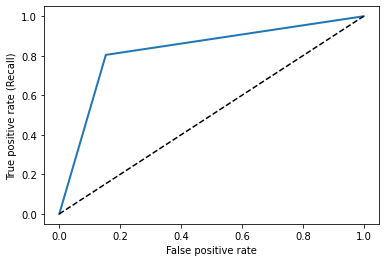

AUC: 0.825813
Misclassified samples: 556


In [318]:
final_model = SVC()
final_model.set_params(**grid.best_params_)
final_model.fit(X_resampled, y_resampled)
svc_pred = final_model.predict(X_test)
print(confusion_matrix(y_test, svc_pred))
print(classification_report(y_test, svc_pred))
count_misclassified = (y_test != svc_pred).sum()

y_scores = cross_val_predict(final_model, X_resampled, y_resampled, cv=3)
fpr, tpr, thresholds = roc_curve(y_resampled, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
 
plot_roc_curve(fpr, tpr)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate (Recall)")
plt.show()

print("AUC: %f" % roc_auc_score(y_resampled, y_scores))

print('Misclassified samples: {}'.format(count_misclassified))

# Decision Tree

## I. Build a decision tree model using sklearns DecisionTreeClassifier. Use the unbalanced training set, entropy as the criterion. Try with different max_depth (or use grid search). After building model, test it and print the confusion matrix and classification report. Also, plot ROC curve and show the AUC of ROC, and the count of the number of misclassification. Show the decision tree. 

In [319]:
param_grid = {'max_depth': range(1, 50)} # create list of paraeters you would like to tune. We have already gone thorugh these parameters in our lecture and note


grid = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'roc_auc', refit=True, cv=3)
grid.fit(X_train, y_train)  #it may take time. We have used verbose = 3 to see some output while it is being processed

grid.best_params_

{'max_depth': 5}

[[2077  165]
 [ 221  224]]
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91      2242
         1.0       0.58      0.50      0.54       445

    accuracy                           0.86      2687
   macro avg       0.74      0.71      0.73      2687
weighted avg       0.85      0.86      0.85      2687



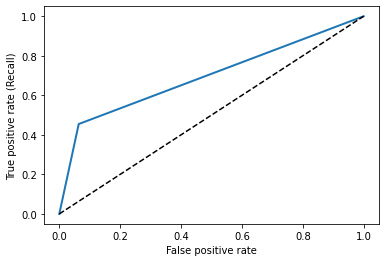

AUC: 0.695429
Misclassified samples: 386


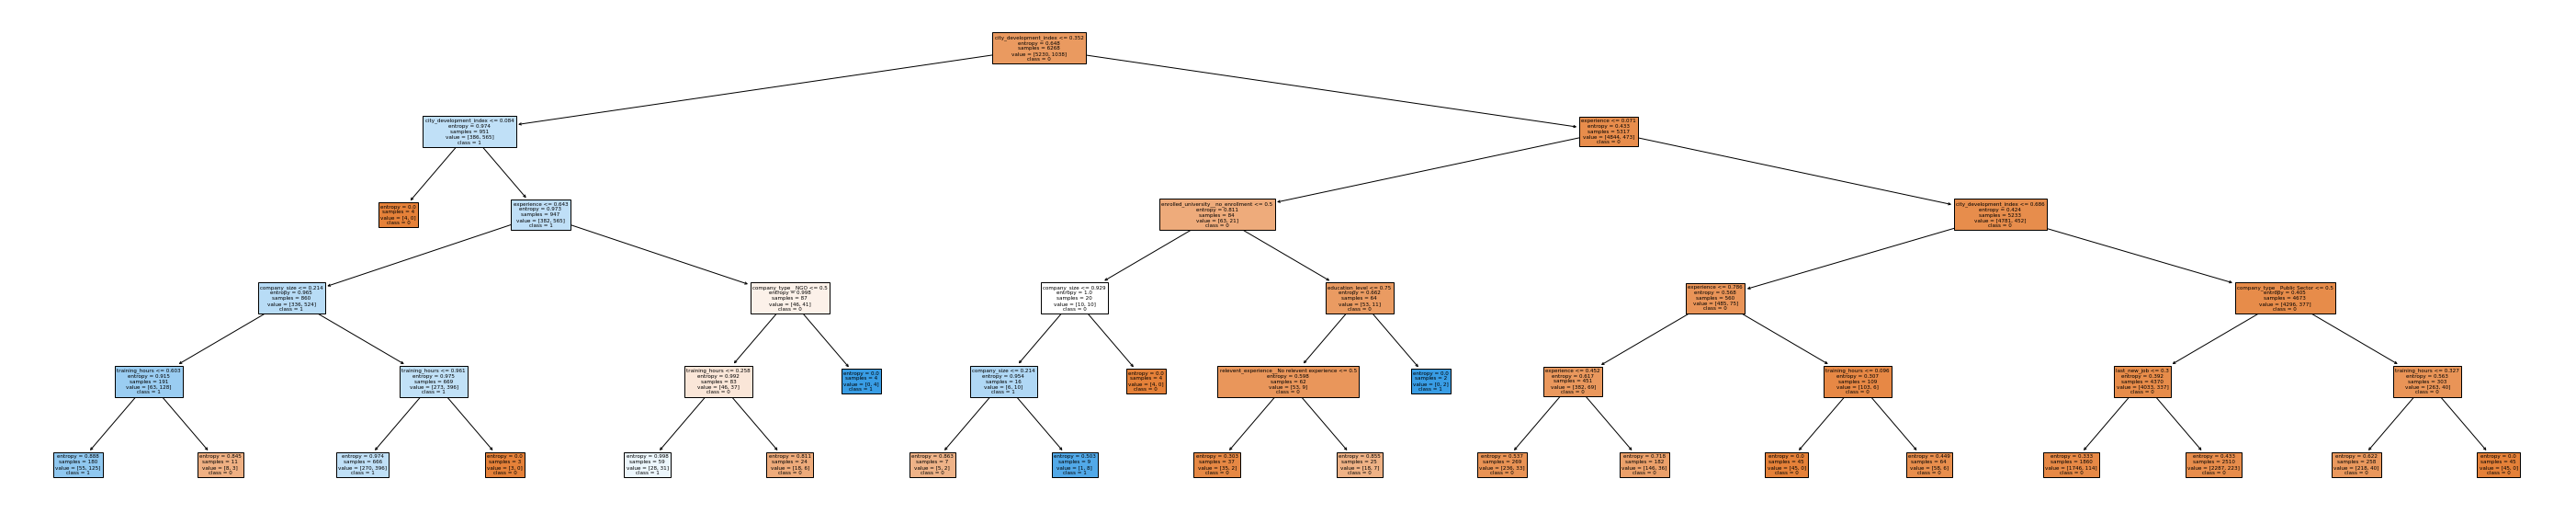

In [320]:
dtree = DecisionTreeClassifier(criterion="entropy", max_depth = grid.best_params_['max_depth'])
dtree.fit(X_train,y_train)
predTree = dtree.predict(X_test)
count_misclassified = (y_test != predTree).sum()

print(confusion_matrix(y_test, predTree))
print(classification_report(y_test, predTree))

y_scores = cross_val_predict(dtree, X_train, y_train, cv=3)
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
 
plot_roc_curve(fpr, tpr)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate (Recall)")
plt.show()

print("AUC: %f" % roc_auc_score(y_train, y_scores))

print('Misclassified samples: {}'.format(count_misclassified))

fig = plt.figure(figsize=(50,10))
tree.plot_tree(dtree,feature_names=X.columns, class_names = ['0','1'], filled=True)
plt.show()

## II. Perform the same tasks as 9.1 with the balanced training set

In [321]:
param_grid = {'max_depth': range(1, 50)} # create list of paraeters you would like to tune. We have already gone thorugh these parameters in our lecture and note


grid = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'accuracy', refit=True, cv=3)
grid.fit(X_resampled, y_resampled)  #it may take time. We have used verbose = 3 to see some output while it is being processed

grid.best_params_

{'max_depth': 21}

[[1884  358]
 [ 237  208]]
              precision    recall  f1-score   support

         0.0       0.89      0.84      0.86      2242
         1.0       0.37      0.47      0.41       445

    accuracy                           0.78      2687
   macro avg       0.63      0.65      0.64      2687
weighted avg       0.80      0.78      0.79      2687



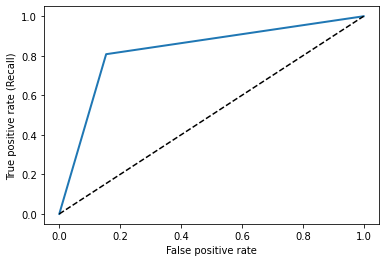

AUC: 0.827055
Misclassified samples: 595


In [322]:
dtree = DecisionTreeClassifier(criterion="entropy", max_depth = grid.best_params_['max_depth'])
dtree.fit(X_resampled,y_resampled)
predTree = dtree.predict(X_test)
count_misclassified = (y_test != predTree).sum()

print(confusion_matrix(y_test, predTree))
print(classification_report(y_test, predTree))

y_scores = cross_val_predict(dtree, X_resampled, y_resampled, cv=3)
fpr, tpr, thresholds = roc_curve(y_resampled, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
 
plot_roc_curve(fpr, tpr)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate (Recall)")
plt.show()

print("AUC: %f" % roc_auc_score(y_resampled, y_scores))

print('Misclassified samples: {}'.format(count_misclassified))

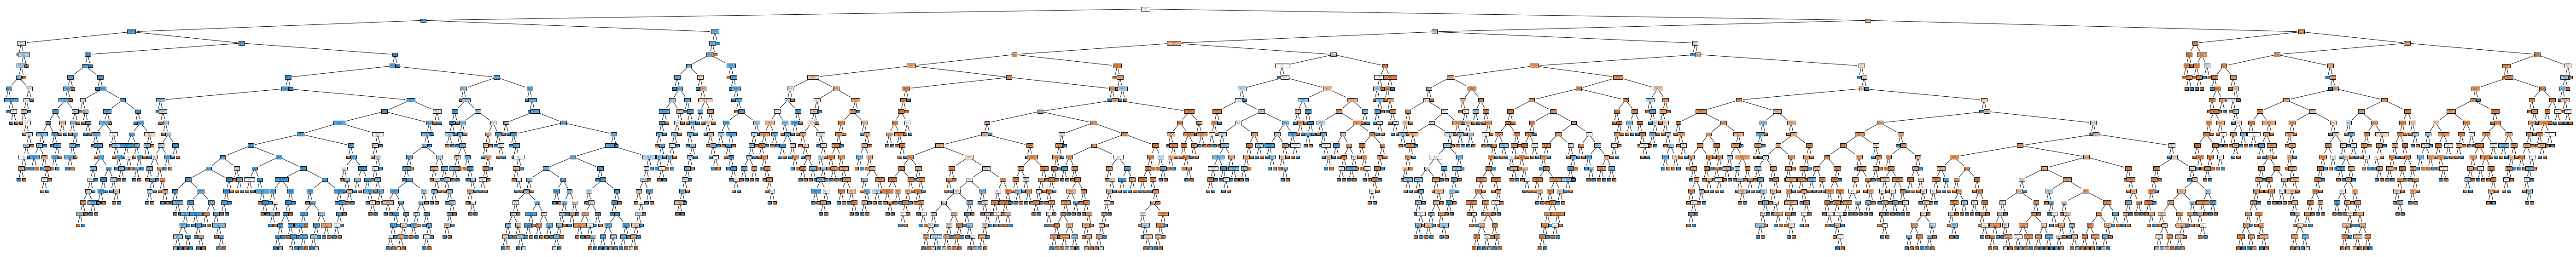

In [323]:
fig = plt.figure(figsize=(100,10))
tree.plot_tree(dtree,feature_names=X.columns, class_names = ['0','1'], filled=True)
plt.show()

## III. Discuss any difference and also discuss part of the tree of 9.2


Decision tree using parameters based on unbalanced training set actually outperforms decision tree using parameters based on balanced training set in terms of misclassification, TN, TP, and accuracy especially. Tree of 9.2 will lean heavily towards the respective classification based off of the first decision.

# Random Forest

## I. Use grid search to tune the max_depth, min_samples_leaf, and n_estimators

In [327]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 3,
                           n_jobs=-1, scoring="accuracy")

grid_search.fit(X_resampled, y_resampled)


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10], 'min_samples_leaf': [50],
                         'n_estimators': [30]},
             scoring='accuracy')

## II. Print the best estimator

In [328]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=10, min_samples_leaf=50, n_estimators=30,
                       n_jobs=-1, random_state=42)

## III. Train the model. After building the model, test it and print the confusion matrix and classification report. Also, plot ROC curve and show the AUC of ROC, and the count of the number of misclassification.


[[2029  213]
 [ 204  241]]
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91      2242
         1.0       0.53      0.54      0.54       445

    accuracy                           0.84      2687
   macro avg       0.72      0.72      0.72      2687
weighted avg       0.85      0.84      0.85      2687



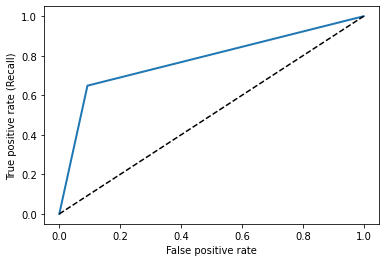

AUC: 0.778107
Misclassified samples: 417


In [329]:
rf_final = grid_search.best_estimator_
rf_final.fit(X_resampled, y_resampled)
rf_pred = rf_final.predict(X_test)
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

count_misclassified = (y_test != rf_pred).sum()

y_scores = cross_val_predict(rf_final, X_resampled, y_resampled, cv=3)
fpr, tpr, thresholds = roc_curve(y_resampled, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
 
plot_roc_curve(fpr, tpr)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate (Recall)")
plt.show()

print("AUC: %f" % roc_auc_score(y_resampled, y_scores))

print('Misclassified samples: {}'.format(count_misclassified))

# Boosting Algorithms

## I. Train an AdaBoostClassifier model with some manual/grid search-based parameters and then test it and then print the confusion matrix and classification report. Also, plot ROC curve and show the AUC of ROC, and the count of the number of misclassification.

In [330]:
dt = DecisionTreeClassifier()
clf = AdaBoostClassifier(n_estimators=100, base_estimator=dt,learning_rate=1)

params = {
    'n_estimators': [10,25,30,50,100]
}

grid_search = GridSearchCV(estimator=clf,
                           param_grid=params,
                           cv = 3,
                           n_jobs=-1, scoring="accuracy")
grid_search.fit(X_resampled, y_resampled)

clf_best = grid_search.best_params_
clf_best


{'n_estimators': 50}

[[2000  242]
 [ 249  196]]
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89      2242
         1.0       0.45      0.44      0.44       445

    accuracy                           0.82      2687
   macro avg       0.67      0.67      0.67      2687
weighted avg       0.82      0.82      0.82      2687



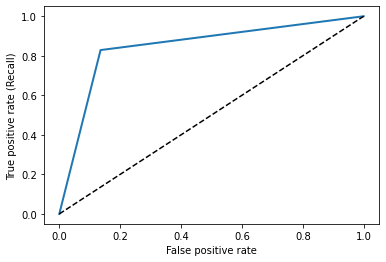

AUC: 0.846654
Misclassified samples: 491


In [331]:
clf_final = AdaBoostClassifier(n_estimators=grid_search.best_params_['n_estimators'], base_estimator=dt,learning_rate=1)
clf_final.fit(X_resampled, y_resampled)
clf_pred = clf_final.predict(X_test)
print(confusion_matrix(y_test, clf_pred))
print(classification_report(y_test, clf_pred))

count_misclassified = (y_test != clf_pred).sum()

y_scores = cross_val_predict(clf_final, X_resampled, y_resampled, cv=3)
fpr, tpr, thresholds = roc_curve(y_resampled, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
 
plot_roc_curve(fpr, tpr)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate (Recall)")
plt.show()

print("AUC: %f" % roc_auc_score(y_resampled, y_scores))

print('Misclassified samples: {}'.format(count_misclassified))

## II. Do the same for Gradient BoostingClassifier

In [332]:
gb = GradientBoostingClassifier()
params = {
    "n_estimators":[5,50,250],
    "max_depth":[1,3,5],
    "learning_rate":[0.01,0.1,1]
}
grid_search = GridSearchCV(estimator=gb,
                           param_grid=params,
                           cv = 3,
                           n_jobs=-1, scoring="accuracy")
grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [1, 3, 5], 'n_estimators': [5, 50, 250]},
             scoring='accuracy')

In [333]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}

[[2093  149]
 [ 241  204]]
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91      2242
         1.0       0.58      0.46      0.51       445

    accuracy                           0.85      2687
   macro avg       0.74      0.70      0.71      2687
weighted avg       0.84      0.85      0.85      2687



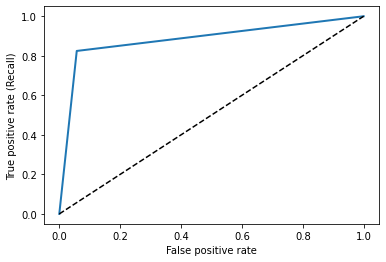

AUC: 0.883556
Misclassified samples: 390


In [334]:
gb_final = GradientBoostingClassifier()
gb_final.set_params(**grid_search.best_params_)
gb_final.fit(X_resampled, y_resampled)
gb_pred = gb_final.predict(X_test)
print(confusion_matrix(y_test, gb_pred))
print(classification_report(y_test, gb_pred))

count_misclassified = (y_test != gb_pred).sum()

y_scores = cross_val_predict(gb_final, X_resampled, y_resampled, cv=3)
fpr, tpr, thresholds = roc_curve(y_resampled, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
 
plot_roc_curve(fpr, tpr)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate (Recall)")
plt.show()

print("AUC: %f" % roc_auc_score(y_resampled, y_scores))

print('Misclassified samples: {}'.format(count_misclassified))

# Finally, briefly discuss your finding such as which model could be most suitable for this given scenario and what could be your future work based on this experiment.


For the given scenario, I would decide to use a Decision Tree, as it performs very well despite the imbalance in the training set. It has the lowest missclassification rate, and some of the highest precision, accuracy out of all the other models. In the future, I would try to rebalance the dataset to include more training instances for a 1 classification. In addition, future models could be built that determine other binary classifications, such as if a stock should be a buy or sell based on multiple components.